# Gene Analysis, Heatmaps and UpSet plots - cBioPortal

In [1]:
from bravado.client import SwaggerClient
from itertools import islice
from collections import defaultdict, OrderedDict
import pandas as pd
import os
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

# just to make API dev easier, hotswap!
import scripts.cbioportal_api
import importlib
importlib.reload(scripts.cbioportal_api)

from scripts.map_enst_to_ensg import get_ensembl_gene_id, get_valid_ensembl_gene_id
from scripts.cbioportal_api import CbioPortalStudy, GeneAnalysis, cancer_type_to_tissue_dictionary

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 10000)        # Set the display width to a large number
pd.set_option('display.max_colwidth', None) # No limit on column width

Old version of pandas detected. Patching DataFrame.map to DataFrame.applymap


In [2]:
base_dir = "/home/jrich/Desktop/CART_prostate_sc"  # os.path.dirname(os.path.dirname(__file__))

In [3]:
run_id = "SAMN10988512_SRX5414523_SRR8615230"
adata_processed_path = os.path.join(base_dir, 'data/output/SAMN10988512_SRX5414523_SRR8615230/data/adata_processed.h5ad')
cbioportal_data_out = os.path.join(base_dir, 'data/reference/cBioPortal')
n = 10


merge_on_gene_name_type = "Symbol"  # "Symbol", "Ensembl"
merge_on_gene_name_type_upset = "Symbol"  # "Symbol", "Ensembl
remove_non_ensembl_genes = False
custom_order = True

data_folder = os.path.join(base_dir, 'data')
output_figure_dir = os.path.join(data_folder, 'output', run_id, 'figures', 'genes')
output_data_dir = os.path.join(data_folder, 'output', run_id, 'data')


if not os.path.exists(output_figure_dir):
    os.makedirs(output_figure_dir)

adata = ad.read_h5ad(adata_processed_path)

/home/jrich/miniconda3/envs/CART2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
cancer_type_key_words = {'esophag', 'ovary', 'ovarian'}

study = CbioPortalStudy()
# study.print_all_study_ids()
# study.make_cancer_type_acronym_dictionary()
# print(study.cancer_type_acronym_dictionary)
# study.print_all_endpoints()
study.find_study_ids_by_keyword(cancer_type_key_words)  #* note: this excludes all mixed studies

['egc_tmucih_2015',
 'egc_msk_2017',
 'egc_mskcc_2020',
 'egc_msk_tp53_ccr_2022',
 'escc_ucla_2014',
 'esca_broad',
 'escc_icgc',
 'egc_trap_msk_2020',
 'hgsoc_msk_2021',
 'lgsoc_mapk_msk_2022',
 'ov_tcga_pub',
 'scco_mskcc',
 'stes_tcga_pub',
 'egc_trap_ccr_msk_2023',
 'esca_tcga',
 'egc_msk_2023',
 'ov_tcga',
 'esca_tcga_pan_can_atlas_2018',
 'ov_tcga_pan_can_atlas_2018',
 'msk_spectrum_tme_2022']

Choose study ID(s)

In [5]:
# study_ids = study.find_study_ids_by_keyword(cancer_type_key_words)
study_ids = "egc_msk_2017"  # ["egc_tmucih_2015", "ov_tcga", "esca_tcga"]  # egc_tmucih_2015, "msk_impact_2017"

In [6]:
gene_analyzer = GeneAnalysis(study_ids = study_ids, cbioportal_data_out_dir = cbioportal_data_out, merge_on_gene_name_type = merge_on_gene_name_type, merge_on_gene_name_type_upset = merge_on_gene_name_type_upset, remove_non_ensembl_genes = remove_non_ensembl_genes, custom_order = custom_order, output_figure_dir = output_figure_dir, output_data_dir = output_data_dir)

In [7]:
gene_analyzer.pick_top_n_most_mutated_genes(adata, n = n)  # gene_analyzer.top_mutant_gene_list

# Downloading data

In [8]:
gene_analyzer.download_cbioportal_data(verbose = False)

Git LFS is not installed or not found in PATH. Proceeding to install without it
File /home/jrich/Desktop/CART_prostate_sc/data/reference/cBioPortal/egc_msk_2017/mutations.txt already exists
File /home/jrich/Desktop/CART_prostate_sc/data/reference/cBioPortal/egc_msk_2017/cna.txt already exists
File /home/jrich/Desktop/CART_prostate_sc/data/reference/cBioPortal/egc_msk_2017/sv.txt already exists
File /home/jrich/Desktop/CART_prostate_sc/data/reference/cBioPortal/egc_msk_2017/clinical_patient.txt already exists
File /home/jrich/Desktop/CART_prostate_sc/data/reference/cBioPortal/egc_msk_2017/clinical_sample.txt already exists


In [9]:
gene_analyzer.big_combined_df

In [10]:
gene_analyzer.create_study_dataframes()  # gene_analyzer.big_combined_df; gene_analyzer.df_collection[study_id][type]  # type = 'mutations', 'samples', 'cna', 'sv'
gene_analyzer.big_combined_df.head(5)
# gene_analyzer.big_combined_df.loc[gene_analyzer.big_combined_df['mutation_occurrences'] > 0]
# gene_analyzer.big_combined_df.loc[gene_analyzer.big_combined_df['cna_occurrences'] > 0]
# gene_analyzer.big_combined_df.loc[gene_analyzer.big_combined_df['sv_occurrences'] > 0]

,Tumor_Sample_Barcode,Hugo_Symbol,Entrez_Gene_Id,Consequence,mutation_occurrences,cna_occurrences,sv_occurrences,study_id,cancer_type,cancer_type_detailed,tissue
0,P-0000062-T01-IM3,EZH2,0.0,missense_variant,1.0,0.0,NaN,egc_msk_2017,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,esophagus
1,P-0000062-T01-IM3,IGF1R,0.0,Multiple_consequences,1.0,0.0,NaN,egc_msk_2017,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,esophagus
2,P-0000062-T01-IM3,KDM5C,0.0,missense_variant,1.0,0.0,NaN,egc_msk_2017,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,esophagus
3,P-0000062-T01-IM3,KEAP1,0.0,missense_variant,1.0,0.0,NaN,egc_msk_2017,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,esophagus
4,P-0000062-T01-IM3,MDM2,0.0,missense_variant,1.0,0.0,NaN,egc_msk_2017,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,esophagus


In [11]:
#!!! erase this box when I am done with dummy data
if gene_analyzer.merge_on_gene_name_type == "Ensembl":
    gene_analyzer.column_for_merging = "Ensembl_Gene_ID"
elif gene_analyzer.merge_on_gene_name_type == "Symbol":
    gene_analyzer.column_for_merging = "Hugo_Symbol"

dummy_df = gene_analyzer.big_combined_df.iloc[:n]
dummy_data = list(dummy_df[gene_analyzer.column_for_merging])
dummy_data.append("XXXXX")
dummy_data.append("YYYYY")
gene_analyzer.top_mutant_gene_list = dummy_data  # total_mutant_gene_list[:n]  
gene_analyzer.top_mutant_gene_list_ensembl_to_hugo = dict(zip(gene_analyzer.top_mutant_gene_list, list(dummy_df['Hugo_Symbol'])))
gene_analyzer.top_mutant_gene_list_ensembl_to_hugo["XXXXX"] = "XXXXX"
gene_analyzer.top_mutant_gene_list_ensembl_to_hugo["YYYYY"] = "YYYYY"

In [12]:
# Just a convenience to hot-reload this function faster
gene_analyzer.plot_heatmap = GeneAnalysis.plot_heatmap.__get__(gene_analyzer, GeneAnalysis)

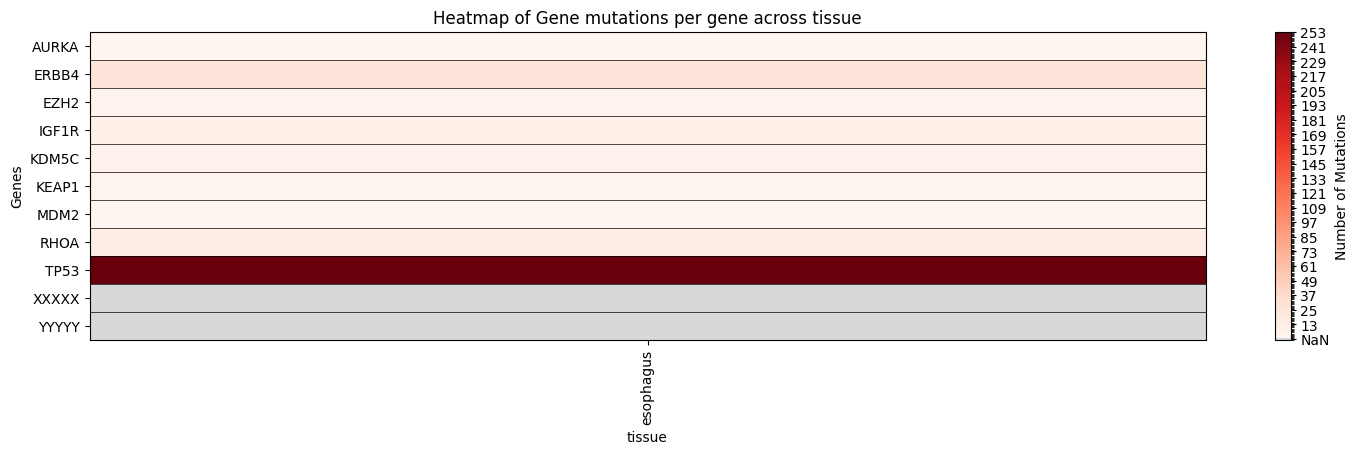

In [13]:
gene_analyzer.plot_heatmap(stratification = "tissue", variation_type = "mutation_occurrences")  #* gene_analyzer.heatmap_df_dict[variation_type], gene_analyzer.pivot_df_dict[variation_type]

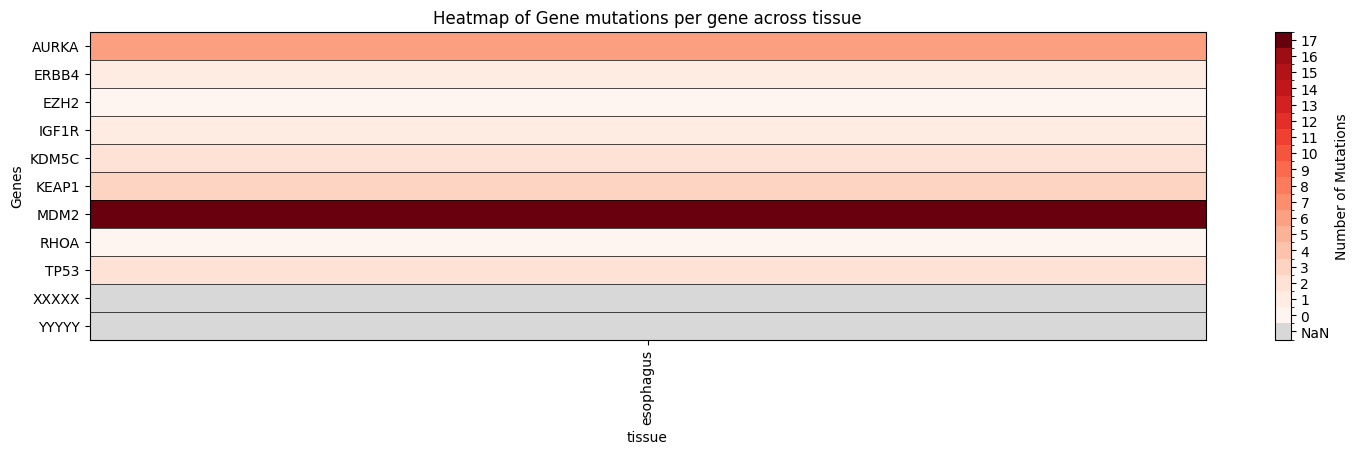

In [14]:
gene_analyzer.plot_heatmap(stratification = "tissue", variation_type = "cna_occurrences")  #* gene_analyzer.heatmap_df_dict[variation_type], gene_analyzer.pivot_df_dict[variation_type]

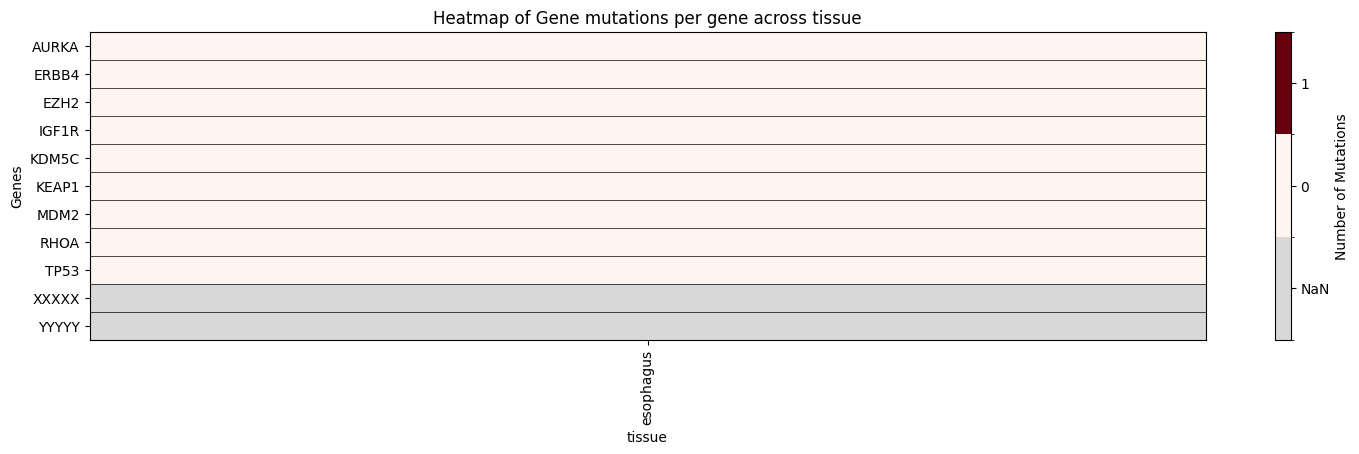

In [15]:
gene_analyzer.plot_heatmap(stratification = "tissue", variation_type = "sv_occurrences")  #* gene_analyzer.heatmap_df_dict[variation_type], gene_analyzer.pivot_df_dict[variation_type]

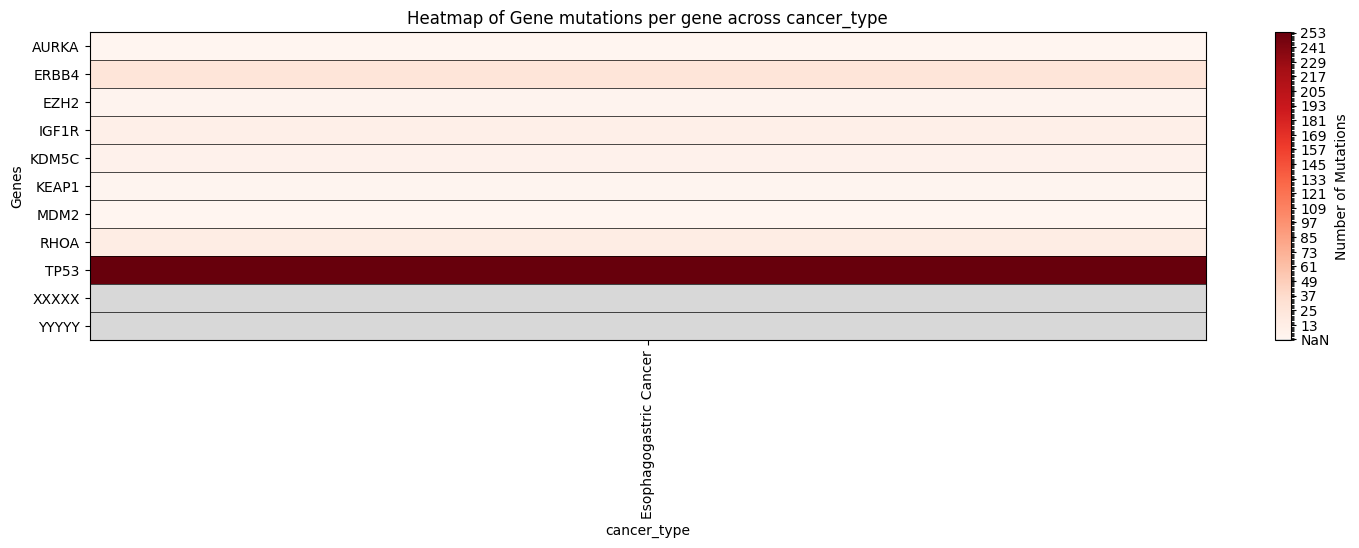

In [16]:
gene_analyzer.plot_heatmap(stratification = "cancer_type", variation_type = "mutation_occurrences")  #* gene_analyzer.heatmap_df_dict[variation_type], gene_analyzer.pivot_df_dict[variation_type]

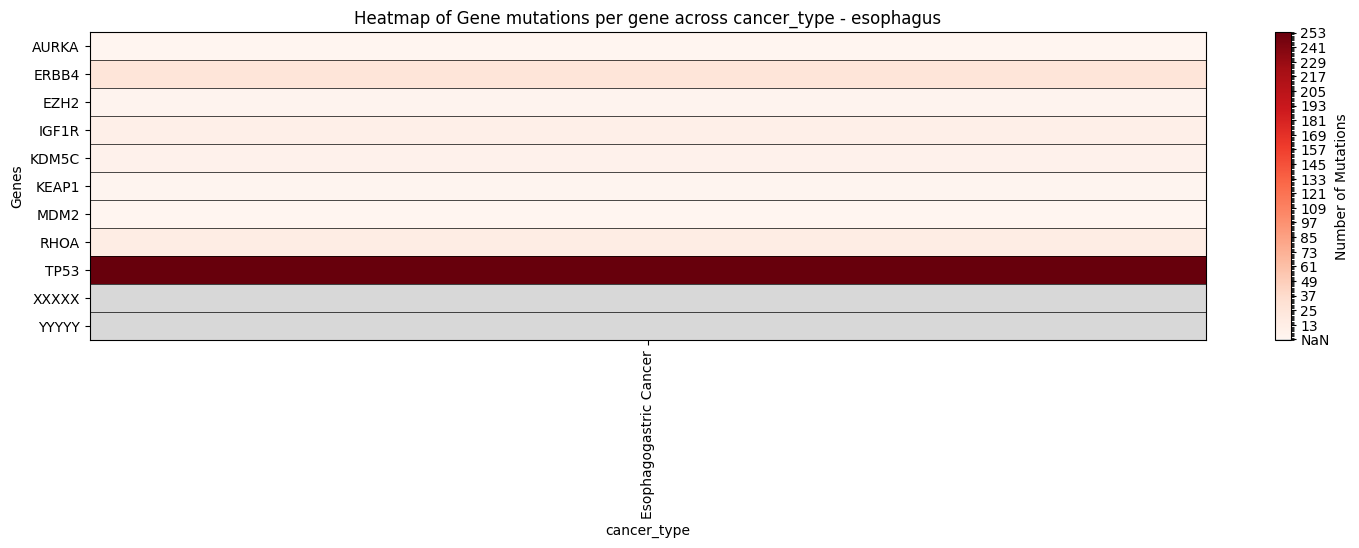

In [17]:
gene_analyzer.tissue_of_interest = 'esophagus'  #* stratify by cancer_type
gene_analyzer.plot_heatmap(stratification = "cancer_type", selected_group = gene_analyzer.tissue_of_interest, selected_group_category = "tissue")  #* gene_analyzer.heatmap_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type], gene_analyzer.pivot_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type]

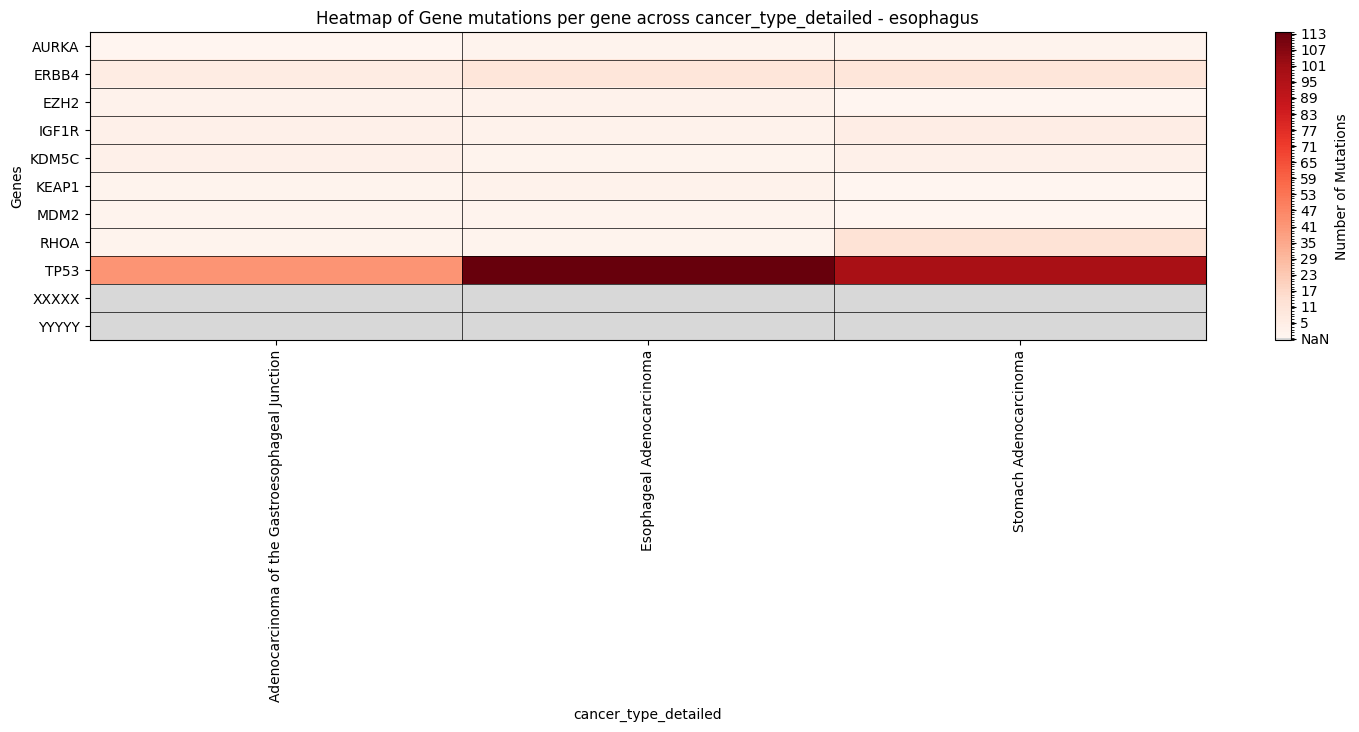

In [18]:
gene_analyzer.plot_heatmap(stratification = "cancer_type_detailed", selected_group = gene_analyzer.tissue_of_interest, selected_group_category = "tissue")  #* gene_analyzer.heatmap_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type], gene_analyzer.pivot_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type]

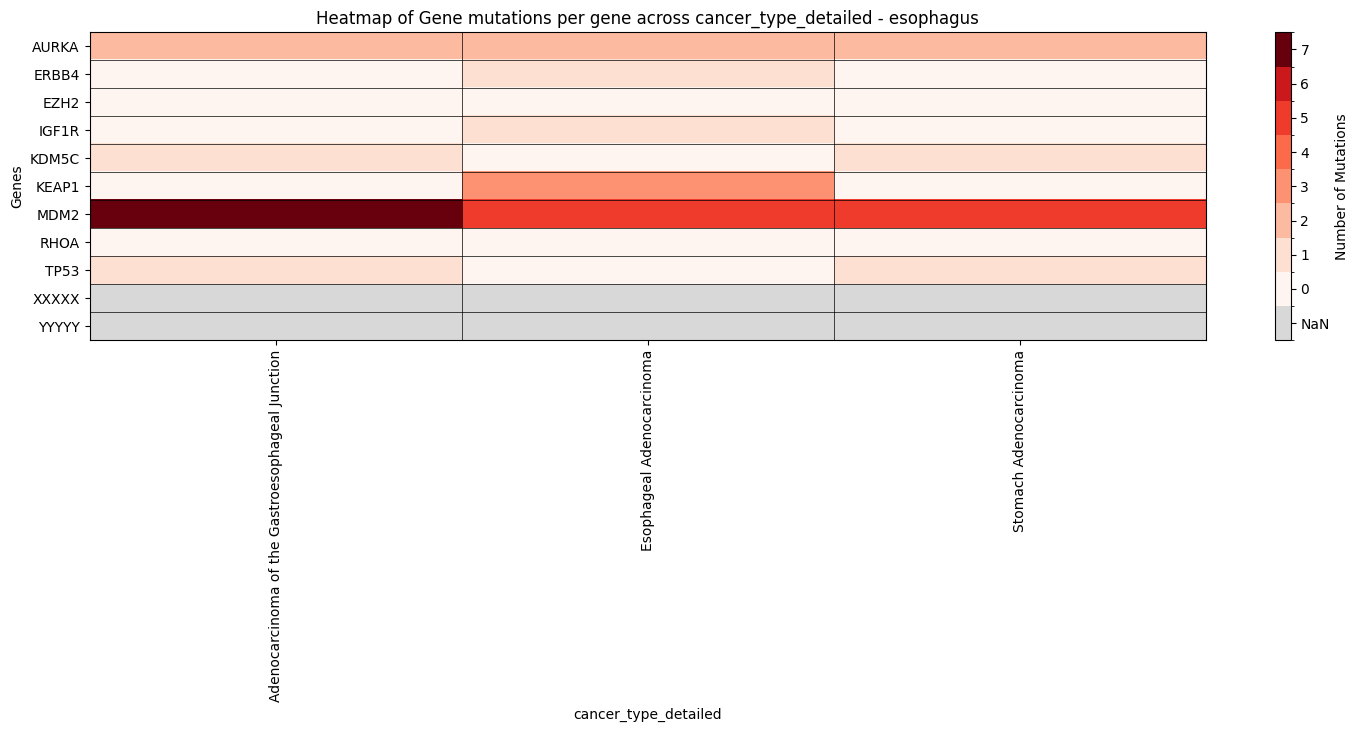

In [19]:
gene_analyzer.plot_heatmap(stratification = "cancer_type_detailed", selected_group = gene_analyzer.tissue_of_interest, selected_group_category = "tissue", variation_type = "cna_occurrences")  #* gene_analyzer.heatmap_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type], gene_analyzer.pivot_df_dict['tissue'][gene_analyzer.tissue_of_interest][variation_type]

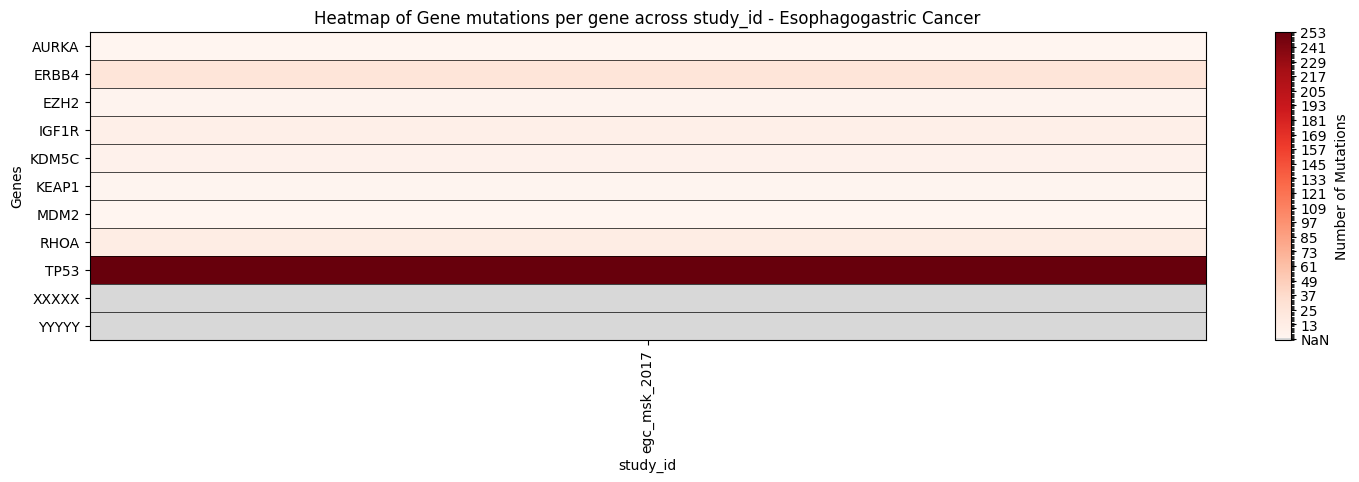

In [20]:
gene_analyzer.cancer_type_of_interest = 'Esophagogastric Cancer'  #* stratify by cancer_type
gene_analyzer.plot_heatmap(stratification = "study_id", selected_group = gene_analyzer.cancer_type_of_interest, selected_group_category = "cancer_type")  #* gene_analyzer.heatmap_df_dict['cancer_type'][gene_analyzer.cancer_type_of_interest][variation_type], gene_analyzer.pivot_df_dict['cancer_type'][gene_analyzer.cancer_type_of_interest][variation_type]

# gene_analyzer.cancer_type_detailed_of_interest = 'Esophagogastric Adenocarcinoma'  #* stratify by cancer_type_detailed
# gene_analyzer.plot_heatmap(stratification = "study_id", selected_group = gene_analyzer.cancer_type_detailed_of_interest, selected_group_category = "cancer_type_detailed")  #* gene_analyzer.heatmap_df_dict['cancer_type_detailed'][gene_analyzer.cancer_type_detailed_of_interest][variation_type], gene_analyzer.pivot_df_dict['cancer_type_detailed'][gene_analyzer.cancer_type_detailed_of_interest][variation_type]

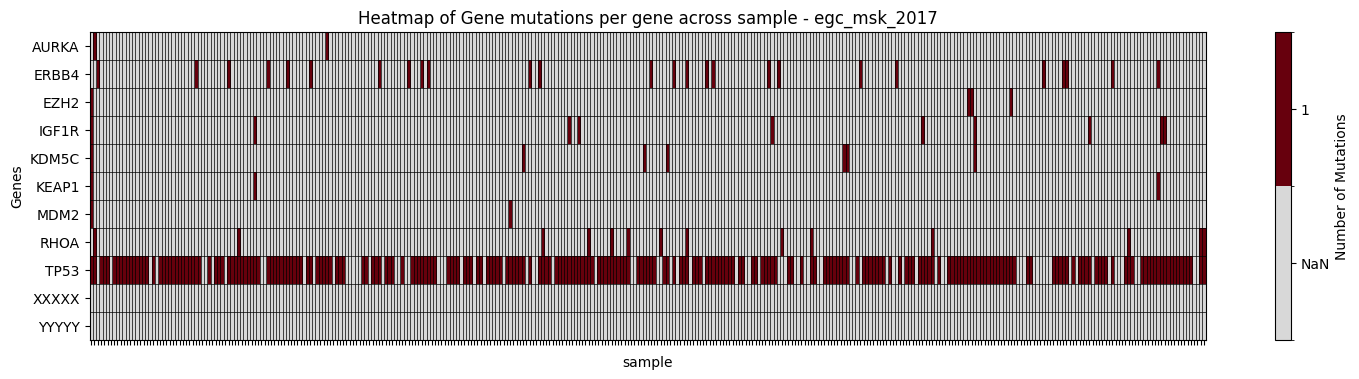

In [21]:
gene_analyzer.study_id_of_interest = 'egc_msk_2017'  #* stratify by sample  #? egc_tmucih_2015
gene_analyzer.plot_heatmap(stratification = "sample", selected_group = gene_analyzer.study_id_of_interest, selected_group_category = "study_id")  #* gene_analyzer.heatmap_df_dict['study_id'][gene_analyzer.study_id_of_interest][variation_type], gene_analyzer.pivot_df_dict['study_id'][gene_analyzer.study_id_of_interest][variation_type]

In [22]:
gene_analyzer.heatmap_df_dict['study_id'][gene_analyzer.study_id_of_interest]["mutation_occurrences"]

,Tumor_Sample_Barcode,cancer_type,cancer_type_detailed,study_id,tissue,Hugo_Symbol,Entrez_Gene_Id,Consequence,mutation_occurrences
0,P-0000062-T01-IM3,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,egc_msk_2017,esophagus,EZH2,0.0,missense_variant,1.0
1,P-0000062-T01-IM3,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,egc_msk_2017,esophagus,IGF1R,0.0,Multiple_consequences,1.0
2,P-0000062-T01-IM3,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,egc_msk_2017,esophagus,KDM5C,0.0,missense_variant,1.0
3,P-0000062-T01-IM3,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,egc_msk_2017,esophagus,KEAP1,0.0,missense_variant,1.0
4,P-0000062-T01-IM3,Esophagogastric Cancer,Adenocarcinoma of the Gastroesophageal Junction,egc_msk_2017,esophagus,MDM2,0.0,missense_variant,1.0
...,...,...,...,...,...,...,...,...,...
3064,P-0018538-T01-IM6,Esophagogastric Cancer,Stomach Adenocarcinoma,egc_msk_2017,esophagus,TP53,NaN,NaN,NaN
3065,P-0018538-T01-IM6,Esophagogastric Cancer,Stomach Adenocarcinoma,egc_msk_2017,esophagus,KEAP1,NaN,NaN,NaN
3066,P-0018538-T01-IM6,Esophagogastric Cancer,Stomach Adenocarcinoma,egc_msk_2017,esophagus,AURKA,NaN,NaN,NaN
3067,P-0018538-T01-IM6,Esophagogastric Cancer,Stomach Adenocarcinoma,egc_msk_2017,esophagus,RHOA,NaN,NaN,NaN


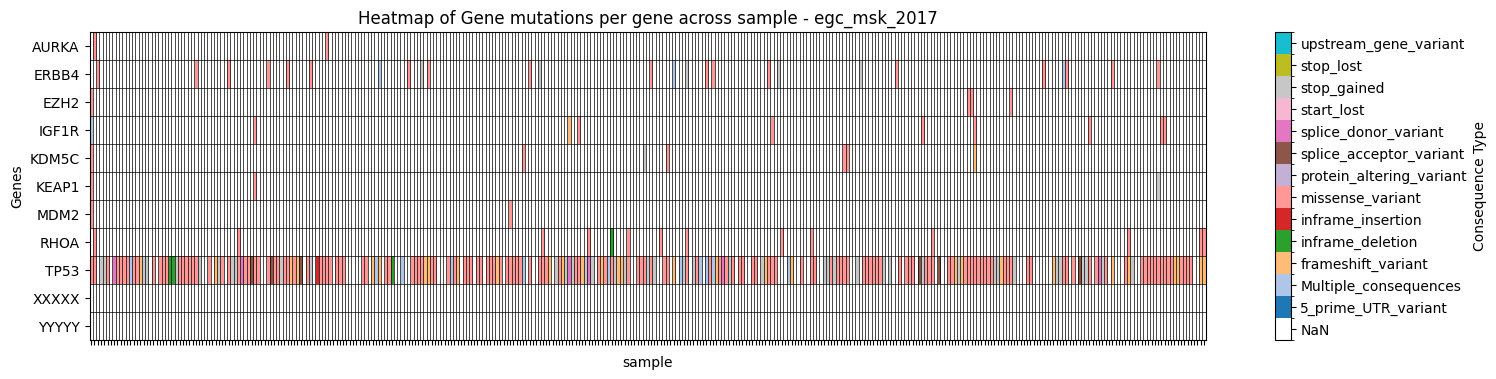

In [23]:
gene_analyzer.plot_heatmap = GeneAnalysis.plot_heatmap.__get__(gene_analyzer, GeneAnalysis)
gene_analyzer.plot_heatmap(stratification = "sample", selected_group = gene_analyzer.study_id_of_interest, selected_group_category = "study_id", variation_type="Consequence")

In [24]:
gene_analyzer.pivot_df_dict['study_id'][gene_analyzer.study_id_of_interest]["mutation_occurrences"].iloc[:, :5]

Tumor_Sample_Barcode,P-0000062-T01-IM3,P-0000076-T01-IM3,P-0000086-T01-IM3,P-0000103-T01-IM3,P-0000112-T01-IM3
AURKA,NaN,1.0,NaN,NaN,NaN
ERBB4,NaN,NaN,1.0,NaN,NaN
EZH2,1.0,NaN,NaN,NaN,NaN
IGF1R,1.0,NaN,NaN,NaN,NaN
KDM5C,1.0,NaN,NaN,NaN,NaN
KEAP1,1.0,NaN,NaN,NaN,NaN
MDM2,1.0,NaN,NaN,NaN,NaN
RHOA,NaN,1.0,NaN,NaN,NaN
TP53,1.0,1.0,NaN,1.0,1.0
XXXXX,NaN,NaN,NaN,NaN,NaN


/home/jrich/Desktop/CART_prostate_sc/scripts/cbioportal_api.py:1149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot_df1 = pivot_df1.append(new_row)
/home/jrich/Desktop/CART_prostate_sc/scripts/cbioportal_api.py:1149: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot_df1 = pivot_df1.append(new_row)


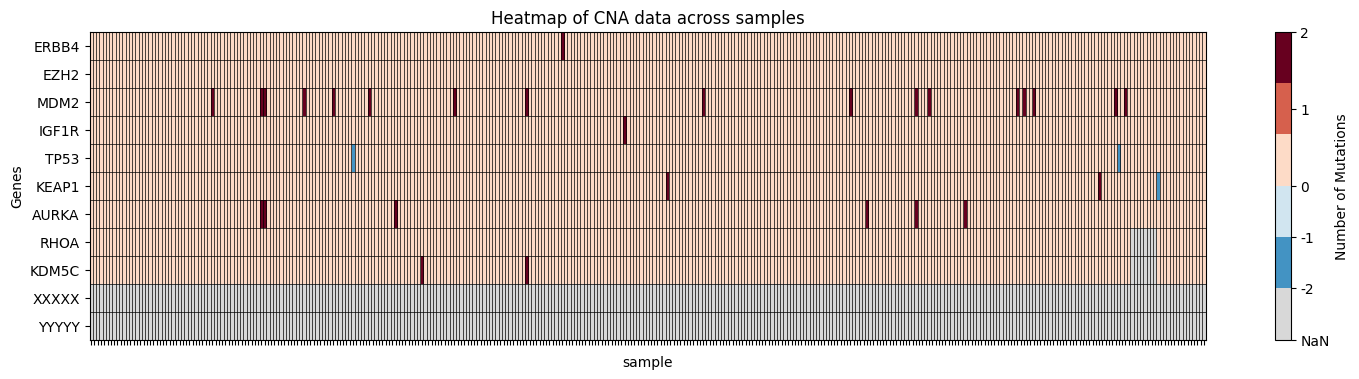

In [25]:
gene_analyzer.plot_heatmap = GeneAnalysis.plot_heatmap.__get__(gene_analyzer, GeneAnalysis)
gene_analyzer.plot_heatmap(stratification = "sample", selected_group = gene_analyzer.study_id_of_interest, selected_group_category = "study_id", variation_type = "cna_nonbinary")  #* gene_analyzer.heatmap_df_dict['study_id'][study_id_of_interest][variation_type], gene_analyzer.pivot_df_dict['study_id'][study_id_of_interest][variation_type]

In [26]:
gene_analyzer.create_summary_table_across_samples(gene_analyzer.study_id_of_interest, variation_type = "mutation_occurrences")
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"]

,Total_Mutations,Samples_With_At_Least_1_Mutation,Fraction_Of_Samples_With_At_Least_1_Mutation
AURKA,2.0,2,0.01
ERBB4,26.0,26,0.08
EZH2,4.0,4,0.01
IGF1R,10.0,10,0.03
KDM5C,7.0,7,0.02
KEAP1,3.0,3,0.01
MDM2,2.0,2,0.01
RHOA,14.0,14,0.04
TP53,253.0,253,0.74
XXXXX,0.0,0,0.00


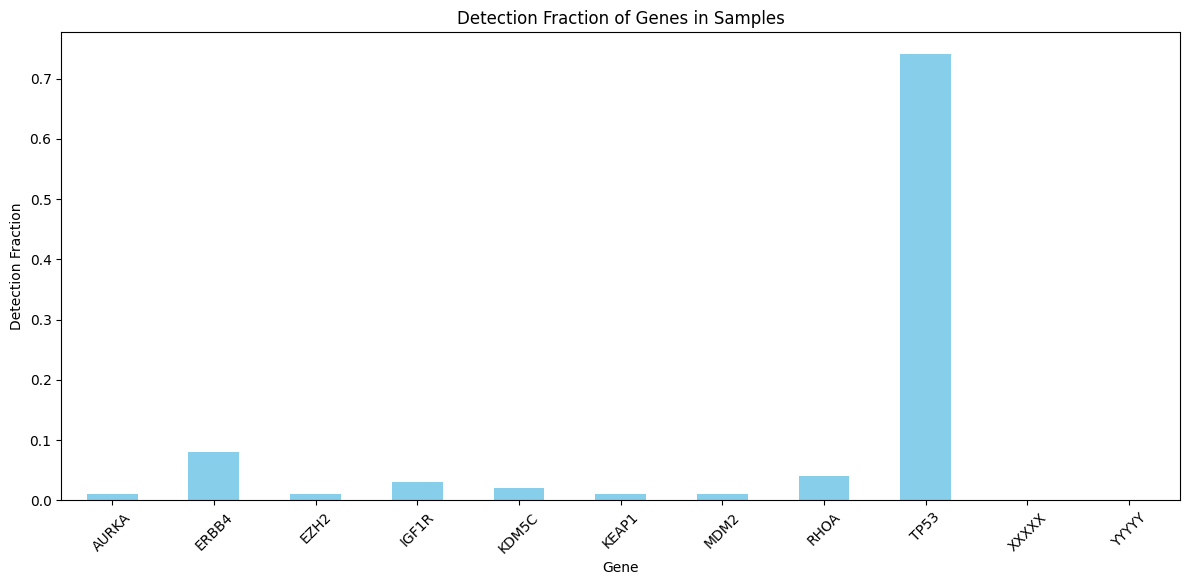

In [27]:
gene_analyzer.plot_fraction_of_samples_over_genes_bargraph(gene_analyzer.study_id_of_interest, variation_type = "mutation_occurrences")

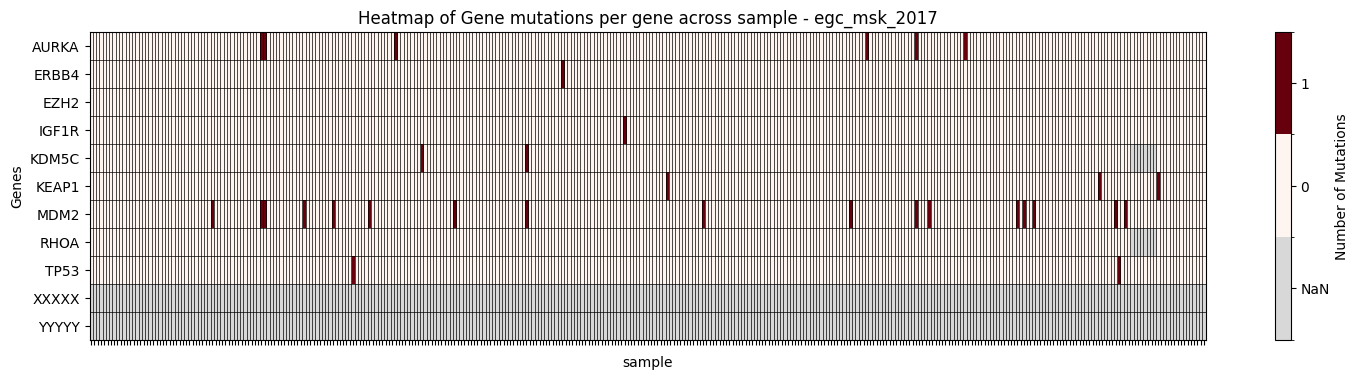

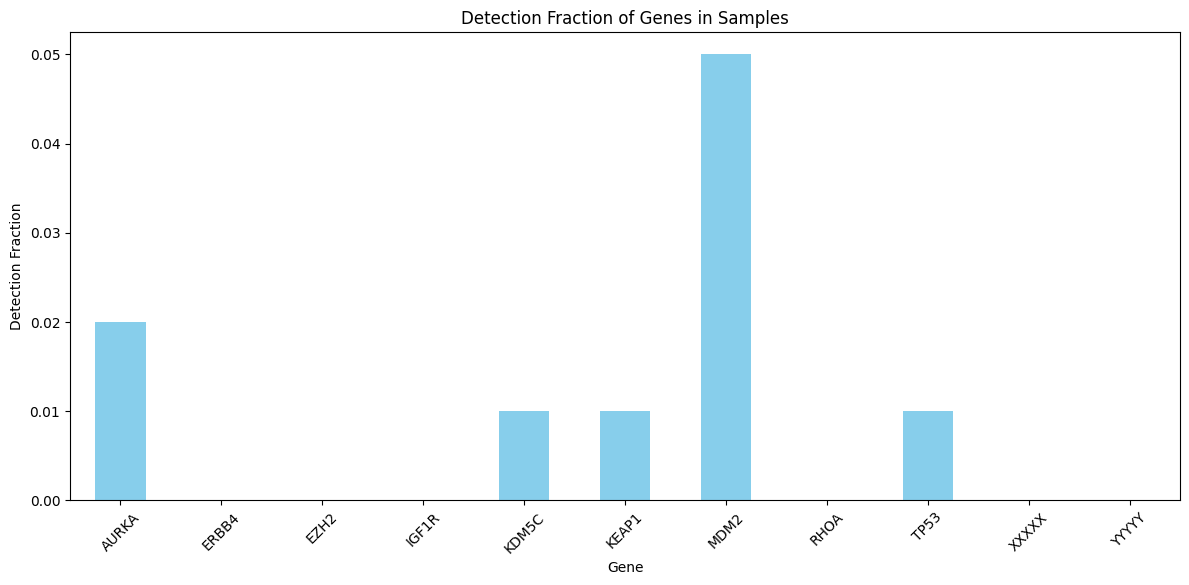

In [28]:
gene_analyzer.plot_heatmap(stratification = "sample", selected_group = gene_analyzer.study_id_of_interest, selected_group_category = "study_id", variation_type = "cna_occurrences")
gene_analyzer.create_summary_table_across_samples(gene_analyzer.study_id_of_interest, variation_type = "cna_occurrences")
gene_analyzer.plot_fraction_of_samples_over_genes_bargraph(gene_analyzer.study_id_of_interest, variation_type = "cna_occurrences")

In [29]:
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["cna_occurrences"]

,Total_Mutations,Samples_With_At_Least_1_Mutation,Fraction_Of_Samples_With_At_Least_1_Mutation
AURKA,6.0,6,0.02
ERBB4,1.0,1,0.00
EZH2,0.0,0,0.00
IGF1R,1.0,1,0.00
KDM5C,2.0,2,0.01
KEAP1,3.0,3,0.01
MDM2,17.0,17,0.05
RHOA,0.0,0,0.00
TP53,2.0,2,0.01
XXXXX,0.0,0,0.00


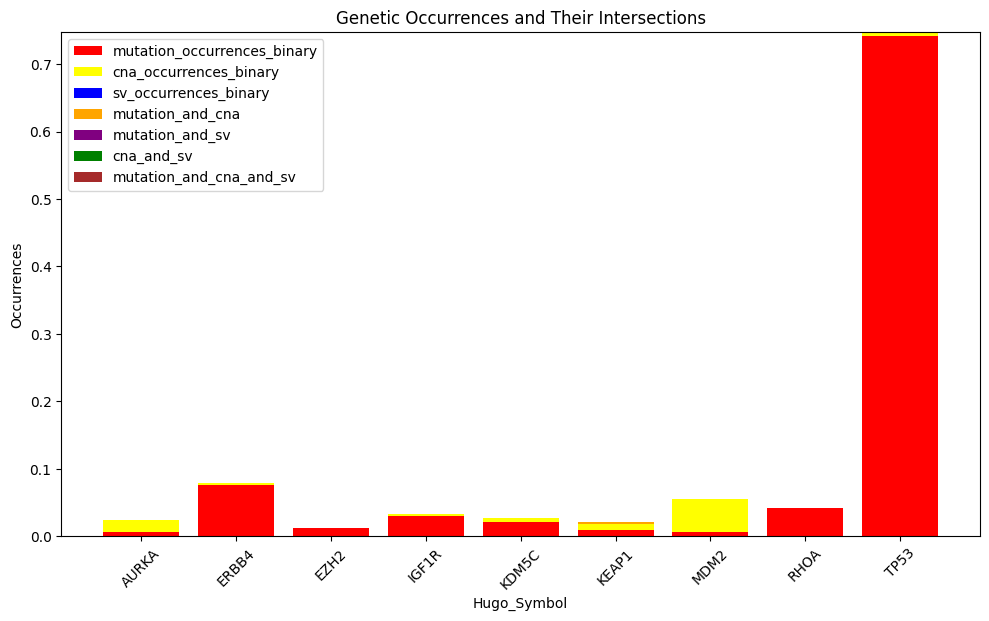

In [30]:
gene_analyzer.plot_fraction_of_samples_over_genes_bargraph(gene_analyzer.study_id_of_interest, variation_type = "combined")

In [31]:
project_dir = "/home/jrich/Desktop/CART_prostate_sc"

cosmic_gene_census_path = os.path.join(project_dir, "data/reference/COSMIC/GRCh37/Cosmic_CancerGeneCensus_Tsv_v100_GRCh37/Cosmic_CancerGeneCensus_v100_GRCh37.tsv")
gene_analyzer.cosmic_gene_census_df = pd.read_csv(cosmic_gene_census_path, sep='\t')

cosmic_hallmark_path = os.path.join(project_dir, "data/reference/COSMIC/GRCh37/Cosmic_CancerGeneCensusHallmarksOfCancer_Tsv_v100_GRCh37/Cosmic_CancerGeneCensusHallmarksOfCancer_v100_GRCh37.tsv")
gene_analyzer.cosmic_hallmark_df = pd.read_csv(cosmic_hallmark_path, sep='\t')

oncokb_path = os.path.join(project_dir, "data/reference/OncoKB/onkokb_cancerGeneList.tsv")
gene_analyzer.oncokb_df = pd.read_csv(oncokb_path, sep='\t')

In [32]:
# hot reload magic
gene_analyzer.make_upset_plot = GeneAnalysis.make_upset_plot.__get__(gene_analyzer, GeneAnalysis)
gene_analyzer.plot_heatmap = GeneAnalysis.plot_heatmap.__get__(gene_analyzer, GeneAnalysis)

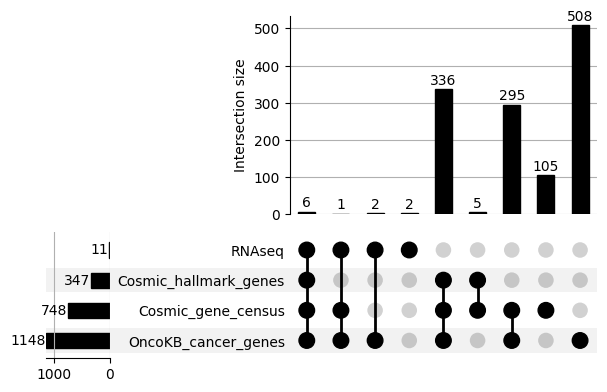

In [33]:
gene_analyzer.make_upset_plot()

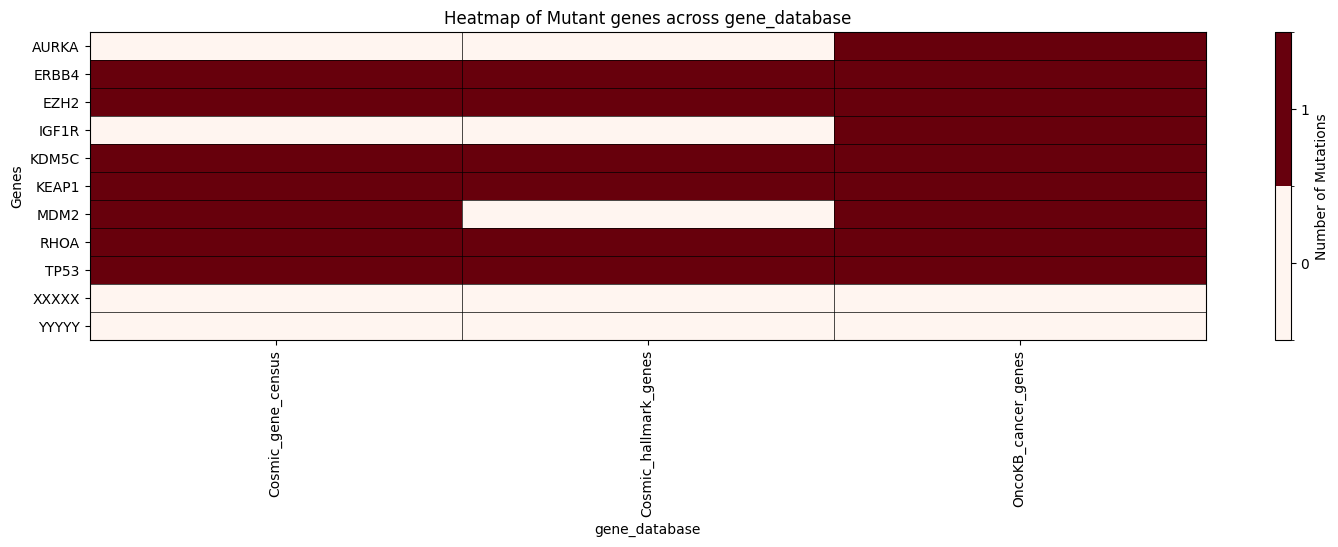

In [34]:
gene_analyzer.plot_heatmap(stratification = "gene_database")  #* gene_analyzer.pivot_df_dict["gene_database"]

In [35]:
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"] = pd.merge(gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"], gene_analyzer.upset_data2, left_index=True, right_index=True, how='left').drop(columns = ['RNAseq'])
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"]

,Total_Mutations,Samples_With_At_Least_1_Mutation,Fraction_Of_Samples_With_At_Least_1_Mutation,Cosmic_gene_census,Cosmic_hallmark_genes,OncoKB_cancer_genes
AURKA,2.0,2,0.01,False,False,True
ERBB4,26.0,26,0.08,True,True,True
EZH2,4.0,4,0.01,True,True,True
IGF1R,10.0,10,0.03,False,False,True
KDM5C,7.0,7,0.02,True,True,True
KEAP1,3.0,3,0.01,True,True,True
MDM2,2.0,2,0.01,True,False,True
RHOA,14.0,14,0.04,True,True,True
TP53,253.0,253,0.74,True,True,True
XXXXX,0.0,0,0.00,False,False,False


In [36]:
pivot_df1_upset = gene_analyzer.pivot_df_dict["gene_database"].copy()

genes_in_cgc = list(pivot_df1_upset[pivot_df1_upset['Cosmic_gene_census'] == True].index)  # replace pivot_df1_upset with upset_data2 for all genes in the database
genes_in_cgc_hallmark = list(pivot_df1_upset[pivot_df1_upset['Cosmic_hallmark_genes'] == True].index)
genes_in_oncokb = list(pivot_df1_upset[pivot_df1_upset['OncoKB_cancer_genes'] == True].index)

genes_in_all_three = list(pivot_df1_upset[
    (pivot_df1_upset['Cosmic_gene_census'] == True) &
    (pivot_df1_upset['Cosmic_hallmark_genes'] == True) &
    (pivot_df1_upset['OncoKB_cancer_genes'] == True)
].index)

print(genes_in_all_three)

['ERBB4', 'EZH2', 'KDM5C', 'KEAP1', 'RHOA', 'TP53']


## Select a gene of interest

In [37]:
gene_of_interest = "AKT1"

In [38]:
gene_analyzer.cosmic_gene_census_df.loc[gene_analyzer.cosmic_gene_census_df[gene_analyzer.cosmic_gene_column] == gene_of_interest]

,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
15,AKT1,AKT serine/threonine kinase 1,COSG9368,14,105235686.0,105262088.0,14q32.33,y,n,"breast, colorectal, ovarian, NSCLC",NaN,NaN,E,Dom,oncogene,Mis,NaN,n,NaN,1,"AKT1,ENSG00000142208.11,P31749,207,AKT,PKB,PRKBA,RAC"


In [39]:
gene_analyzer.cosmic_hallmark_df.loc[gene_analyzer.cosmic_hallmark_df[gene_analyzer.cosmic_gene_column] == gene_of_interest]

,GENE_SYMBOL,COSMIC_GENE_ID,CELL_TYPE,PUBMED_PMID,HALLMARK,IMPACT,DESCRIPTION,CELL_LINE
2202,AKT1,COSG9368,colorectal cancer,28339062.0,escaping programmed cell death,promotes,suppresses the cell apoptosis induced by DNA damage,HCT116 and HT29
2203,AKT1,COSG9368,NaN,17611497.0,impact of mutation on function,NaN,"Lys 17 alters the electrostatic interactions of the lipid-binding pocket and forms new hydrogen bonds with a phosphoinositide ligand, resulting in hyperactivation of AKT1 by means of pathological localization to the plasma membrane and stimulation of downstream signalling",NaN
2204,AKT1,COSG9368,lung cancer,21242979.0,function summary,NaN,fibroblasts lacking Akt1 are resistant to transformation by mutant K-ras and stimulation by epidermal growth factor,NaN
2205,AKT1,COSG9368,breast cancer,27004402.0,proliferative signalling,promotes,induces mammary hyperplasia,NaN
2206,AKT1,COSG9368,breast cancer,27004402.0,suppression of growth,promotes,"prevents HER2-driven tumorigenesis, in part through negative feedback inhibition of RTK signalling",NaN
2207,AKT1,COSG9368,melanocytes,25551293.0,escaping programmed cell death,promotes,promotes growth factor independent survival in a kinase-independent way,NaN
2208,AKT1,COSG9368,haemangioma,25388284.0,escaping programmed cell death,promotes,KD results in increased tumour cell apoptosis in response to serum starvation,NaN
2209,AKT1,COSG9368,haemangioma,25388284.0,invasion and metastasis,promotes,KD decreases basal and VEGF-stimulated cell migration,NaN
2210,AKT1,COSG9368,prostate cancer,25322691.0,change of cellular energetics,promotes,AKT1 activation is associated with accumulation of aerobic glycolysis metabolites,NaN
2211,AKT1,COSG9368,hepatocellular carcinoma,24297510.0,invasion and metastasis,promotes,enforced expression of Akt1 induces cell migration and invasion,HepG2


In [40]:
gene_analyzer.oncokb_df.loc[gene_analyzer.oncokb_df[gene_analyzer.oncokb_gene_column] == gene_of_interest]

,Hugo Symbol,Entrez Gene ID,GRCh37 Isoform,GRCh37 RefSeq,GRCh38 Isoform,GRCh38 RefSeq,Is Oncogene,Is Tumor Suppressor Gene,# of occurrence within resources (Column J-P),OncoKB Annotated,MSK-IMPACT,MSK-HEME,FOUNDATION ONE,FOUNDATION ONE HEME,Vogelstein,COSMIC CGC (v99),Gene Aliases
1,AKT1,207,ENST00000349310,NM_001014431.1,ENST00000349310,NM_001014431.1,Yes,No,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,"AKT, PKB, PRKBA, RAC, RAC-alpha"


In [41]:
#!!! ERASE

row_to_copy = gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"].iloc[0]

# Create a new DataFrame with the new index 'ABL1'
new_row = pd.DataFrame([row_to_copy], index=['ABL1'])

# Append the new row to the original DataFrame
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"] = pd.concat([gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"], new_row])

In [42]:
gene_analyzer.cosmic_hallmark_df_combined_gene_rows = gene_analyzer.cosmic_hallmark_df.groupby(['GENE_SYMBOL', 'COSMIC_GENE_ID']).agg(lambda x: ','.join(x.astype(str))).reset_index()

In [43]:
gene_analyzer.cosmic_cgc_features_of_interest = ['TUMOUR_TYPES_SOMATIC', 'TUMOUR_TYPES_GERMLINE', 'CANCER_SYNDROME', 'ROLE_IN_CANCER', 'TRANSLOCATION_PARTNER', 'TIER']
gene_analyzer.cosmic_hallmark_features_of_interest = ['CELL_TYPE', 'HALLMARK', 'IMPACT']

gene_analyzer.cosmic_features_of_interest = gene_analyzer.cosmic_cgc_features_of_interest + gene_analyzer.cosmic_hallmark_features_of_interest
for feature in gene_analyzer.cosmic_features_of_interest:
    if feature in gene_analyzer.cosmic_gene_census_df.columns:
        feature_name = f"cosmic_gene_census_{feature}"
        cosmic_gene_census_dict = gene_analyzer.cosmic_gene_census_df.set_index(gene_analyzer.cosmic_gene_column)[feature].to_dict()
        gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"][feature_name] = gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"].index.map(lambda gene: cosmic_gene_census_dict.get(gene, np.nan))
    elif feature in gene_analyzer.cosmic_hallmark_df_combined_gene_rows.columns:
        feature_name = f"cosmic_hallmark_{feature}"
        cosmic_hallmark_dict = gene_analyzer.cosmic_hallmark_df_combined_gene_rows.set_index(gene_analyzer.cosmic_gene_column)[feature].to_dict()
        gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"][feature_name] = gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"].index.map(lambda gene: cosmic_hallmark_dict.get(gene, np.nan))
    else:
        raise ValueError(f"Feature {feature} not found in Cosmic dataframes")

In [57]:
gene_analyzer.pivot_df_summary_across_samples_dict[gene_analyzer.study_id_of_interest]["mutation_occurrences"].head()

,Total_Mutations,Samples_With_At_Least_1_Mutation,Fraction_Of_Samples_With_At_Least_1_Mutation,Cosmic_gene_census,Cosmic_hallmark_genes,OncoKB_cancer_genes,cosmic_gene_census_TUMOUR_TYPES_SOMATIC,cosmic_gene_census_TUMOUR_TYPES_GERMLINE,cosmic_gene_census_CANCER_SYNDROME,cosmic_gene_census_ROLE_IN_CANCER,cosmic_gene_census_TRANSLOCATION_PARTNER,cosmic_gene_census_TIER,cosmic_hallmark_CELL_TYPE,cosmic_hallmark_HALLMARK,cosmic_hallmark_IMPACT
AURKA,2.0,2,0.01,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ERBB4,26.0,26,0.08,True,True,True,"melanoma, gastric, NSCLC",NaN,NaN,"oncogene, TSG",NaN,1.0,"mouse,oral cancer,nan,nan,breast cancer,NSCLC,nan,breast cancer,nan,NSCLC,breast cancer,melanoma,breast cancer,breast cancer,breast cancer,NSCLC","mouse model,types of alteration in cancer,types of alteration in cancer,differentiation and development,cell division control,impact of mutation on function,function summary,escaping programmed cell death,escaping programmed cell death,escaping programmed cell death,proliferative signalling,proliferative signalling,suppression of growth,role in cancer,role in cancer,role in cancer","nan,nan,nan,nan,nan,nan,nan,promotes,suppresses,promotes,promotes,promotes,promotes,TSG,oncogene,oncogene"
EZH2,4.0,4,0.01,True,True,True,DLBCL,NaN,NaN,"oncogene, TSG",NaN,1.0,"glioblastoma,lung adenocarcinoma,cutaneous anaplastic T-cell lymphoma,liver cancer,gastric cancer,nan,nan,breast cancer,nan,neuroblastoma,nan,cutaneous anaplastic large cell lymphoma,multiple myeloma,head and neck squamous cell carcinoma,nan,DLBCL,melanoma,melanoma,nan,cutaneous anaplastic T-cell lymphoma,breast cancer,triple-negatve breast cancer PDXs,myeloproliferative diseases,nan,nan,nan,nan,breast cancer,ovarian cancer,cutaneous anaplastic large cell lymphoma,cholangiocarcinoma,cutaneous anaplastic T-cell lymphoma,head and neck squamous cell carcinoma,osteosarcoma,neuroblastoma,cholangiocarcinoma,ovarian cancer,renal cell carcinoma,lung adenocarcinoma,cholangiocarcinoma","change of cellular energetics,suppression of growth,escaping immune response to cancer,escaping immune response to cancer,senescence,role in cancer,role in cancer,clinical impact,types of alteration in cancer,differentiation and development,differentiation and development,cell division control,cell division control,cell division control,clinical impact,global regulation of gene expression,invasion and metastasis,proliferative signalling,impact of mutation on function,global regulation of gene expression,clinical impact,invasion and metastasis,types of alteration in cancer,mouse model,function summary,genome instability and mutations,clinical impact,genome instability and mutations,angiogenesis,escaping programmed cell death,escaping programmed cell death,escaping programmed cell death,escaping programmed cell death,proliferative signalling,proliferative signalling,proliferative signalling,invasion and metastasis,invasion and metastasis,tumour promoting inflammation,change of cellular energetics","promotes,promotes,promotes,promotes,suppresses,oncogene, TSG,oncogene, TSG,promotes,nan,nan,nan,nan,nan,nan,nan,nan,promotes,promotes,nan,nan,nan,promotes,nan,nan,nan,suppresses,nan,promotes,promotes,promotes,promotes,promotes,promotes,promotes,promotes,promotes,promotes,promotes,suppresses,promotes"
IGF1R,10.0,10,0.03,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KDM5C,7.0,7,0.02,True,True,True,clear cell renal carcinoma,NaN,NaN,TSG,NaN,1.0,"gastric cancer,intrahepatic cholangiocarcinoma,renal cell carcinoma,intrahepatic cholangiocarcinoma,prostate cancer,breast cancer,clear cell renal cell carcinoma,gastric cancer,intrahepatic cholangiocarcinoma,murine amygdala, frontal cortex,xenopus laevis embryo,xenopus laevis embryo,nan,colon cancer,clear cell renal cell carcinoma,nan,porcine embryo,xenopus laevis embryo,colon cancer,gastric cancer,prostate cancer,xenopus laevis embryo,breast cancer,gastric cancer,intrahepatic cholangiocarcinoma,intrahepatic cholangiocarci

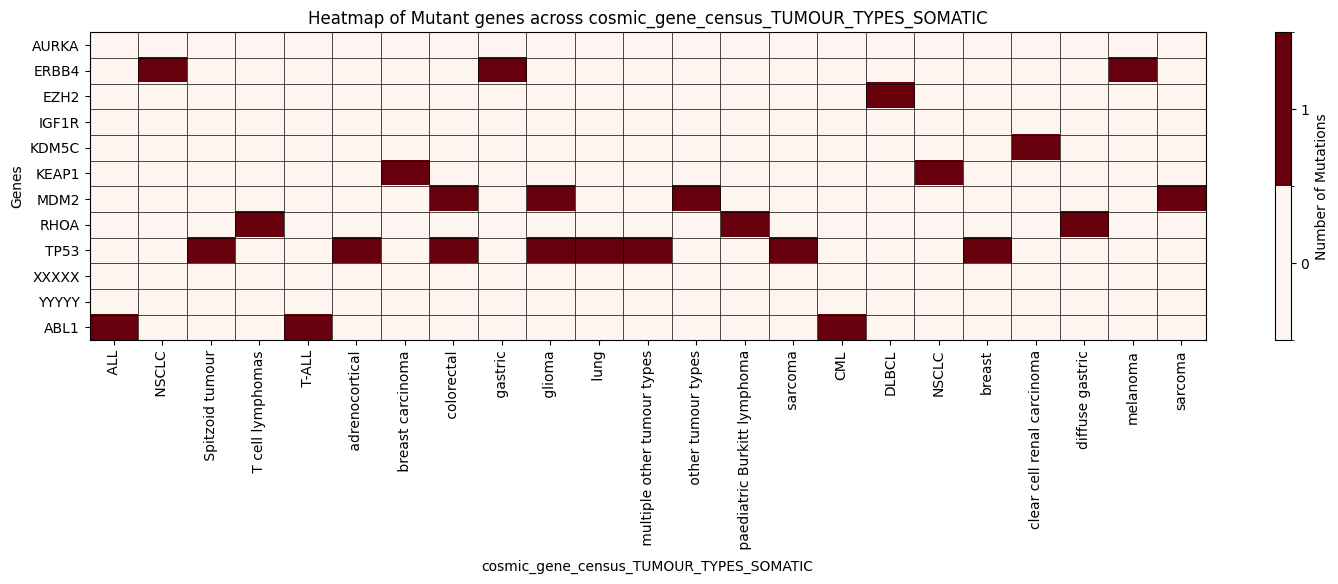

In [45]:
gene_analyzer.plot_heatmap(stratification = "cosmic_gene_census_TUMOUR_TYPES_SOMATIC")  #* gene_analyzer.pivot_df_dict["gene_database"]

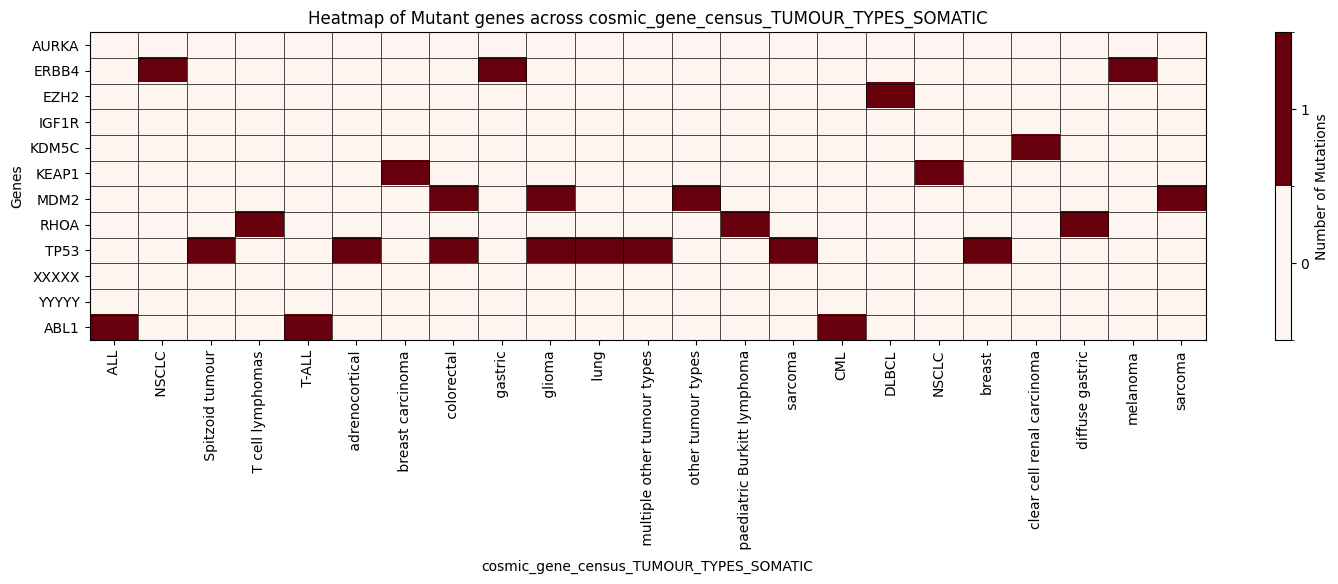

In [46]:
gene_analyzer.plot_heatmap(stratification = "cosmic_gene_census_TUMOUR_TYPES_SOMATIC")  #* gene_analyzer.pivot_df_dict["cosmic_gene_census_TUMOUR_TYPES_SOMATIC"]

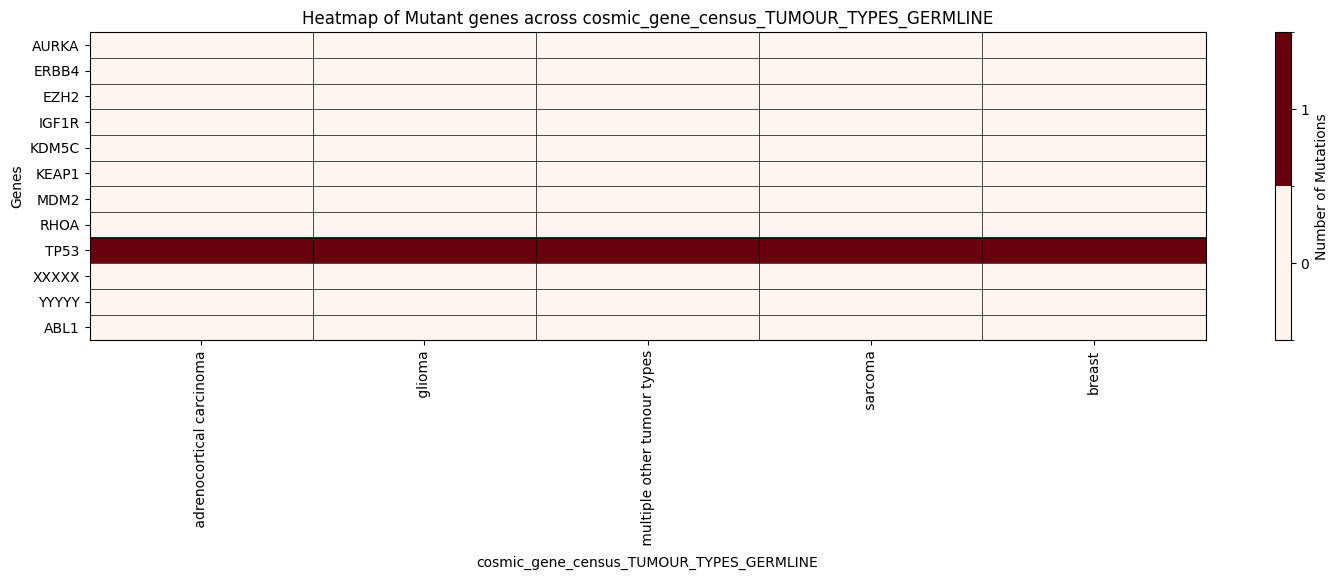

In [47]:
gene_analyzer.plot_heatmap(stratification = "cosmic_gene_census_TUMOUR_TYPES_GERMLINE")  #* gene_analyzer.pivot_df_dict["cosmic_gene_census_TUMOUR_TYPES_GERMLINE"]

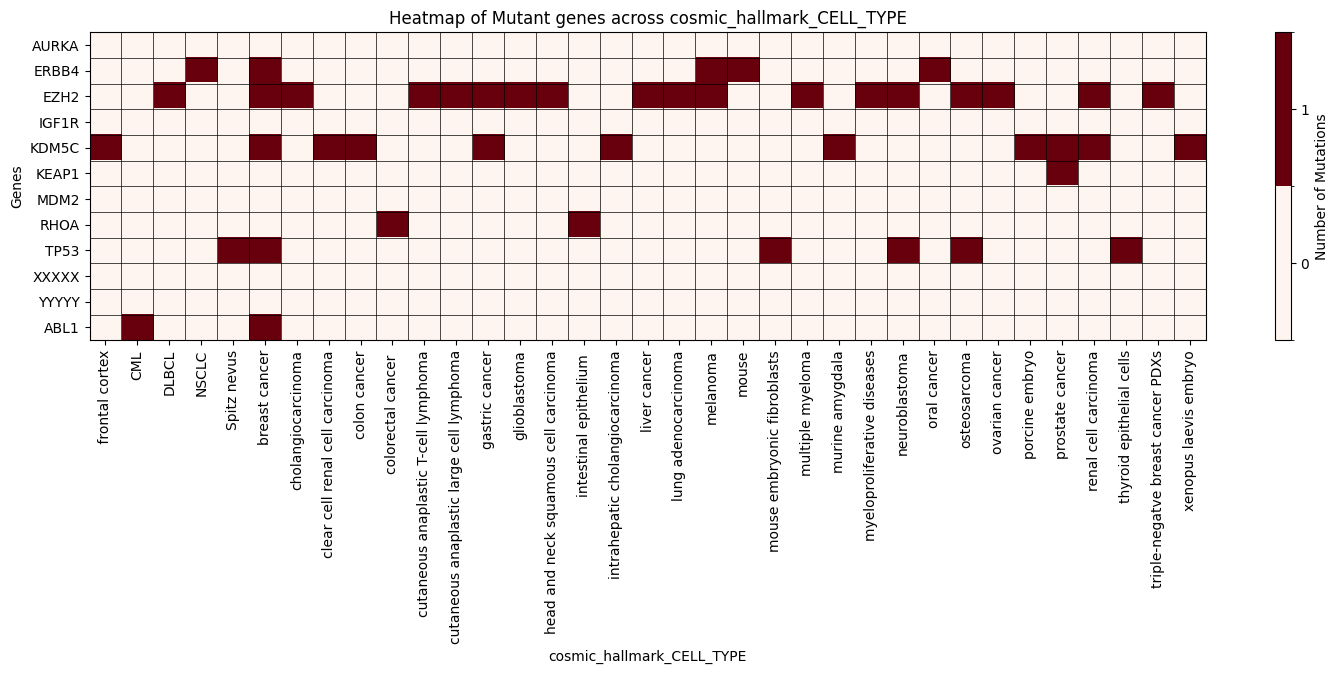

In [48]:
gene_analyzer.plot_heatmap(stratification = "cosmic_hallmark_CELL_TYPE")  #* gene_analyzer.pivot_df_dict["cosmic_hallmark_CELL_TYPE"]

In [ ]:
cosmic_classification_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_Classification_Tsv_v100_GRCh37/Cosmic_Classification_v100_GRCh37.tsv"
cosmic_classification_df = pd.read_csv(cosmic_classification_path, sep='\t')

# Working with API

In [49]:
# study_id = "msk_impact_2017"
# study.study_id = study_id
# # study.list_attributes_keys()

In [50]:
# study.print_study_summary_info()
# study.print_cancer_type_information()

In [51]:
# if study.cancer_type_id == "mixed":
#     # print(sorted(study.unique_cancer_types))
#     # print(sorted(study.unique_cancer_type_detailed))
#     cancer_types_name = "Esophagus"

#     cancer_types = [value for value in study.unique_cancer_types if 'esoph' in value.lower()]  # make cancer_types either by manually selecting from study.unique_cancer_types or by keyword search as shown here
#     print(cancer_types)
#     study.get_specific_cancer_information(cancer_types = cancer_types, cancer_type_category = 'CANCER_TYPE', cancer_types_name = cancer_types_name)

#     print('---------------')

#     cancer_types_detailed = [value for value in study.unique_cancer_type_detailed if 'esoph' in value.lower()]  # make cancer_types_detailed either by manually selecting from study.unique_cancer_type_detailed or by keyword search as shown here
#     print(cancer_types_detailed)
#     study.get_specific_cancer_information(cancer_types = cancer_types_detailed, cancer_type_category = 'CANCER_TYPE_DETAILED', cancer_types_name = cancer_types_name)

In [52]:
# print(study.cancer_type_mutations)
# print(study.cancer_type_mutated_genes)
# print(study.cancer_type_mutations_detailed)
# print(study.cancer_type_mutated_genes_detailed)

In [53]:
# study.cancer_type_mutations[2]  # ['chr'], ['gene']['hugoGeneSymbol'], ['gene']['type'], ['mutationType'], ['ncbiBuild'], ['proteinChange'], ['proteinPosEnd'], ['proteinPosStart'], '[tumorAltCount'], ['tumorRefCount'], ['sampleId'], ['startPosition'], ['endPosition'], ['referenceAllele'], ['variantAllele']
# # Mutation(alleleSpecificCopyNumber=None, aminoAcidChange=None, center='NA', chr='2', driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, endPosition=158636926, entrezGeneId=90, gene=Gene(entrezGeneId=90, geneticEntityId=None, hugoGeneSymbol='ACVR1', type='protein-coding'), keyword='ACVR1 P85 missense', molecularProfileId='msk_impact_2017_mutations', mutationStatus='NA', mutationType='Missense_Mutation', namespaceColumns=None, ncbiBuild='GRCh37', normalAltCount=None, normalRefCount=None, patientId='P-0010220', proteinChange='P85L', proteinPosEnd=85, proteinPosStart=85, referenceAllele='G', refseqMrnaId='NM_001105.4', sampleId='P-0010220-T01-IM5', startPosition=158636926, studyId='msk_impact_2017', tumorAltCount=346, tumorRefCount=396, uniquePatientKey='UC0wMDEwMjIwOm1za19pbXBhY3RfMjAxNw', uniqueSampleKey='UC0wMDEwMjIwLVQwMS1JTTU6bXNrX2ltcGFjdF8yMDE3', validationStatus='NA', variantAllele='A', variantType='SNP')

In [54]:
# study.get_cna_info()
# # study.cna_info[0]
# # DiscreteCopyNumberData(alteration=2, driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, entrezGeneId=5395, gene=Gene(entrezGeneId=5395, geneticEntityId=None, hugoGeneSymbol='PMS2', type='protein-coding'), molecularProfileId='msk_impact_2017_cna', namespaceColumns=None, patientId='P-0000004', sampleId='P-0000004-T01-IM3', studyId='msk_impact_2017', uniquePatientKey='UC0wMDAwMDA0Om1za19pbXBhY3RfMjAxNw', uniqueSampleKey='UC0wMDAwMDA0LVQwMS1JTTM6bXNrX2ltcGFjdF8yMDE3')